In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import *
from sklearn.preprocessing import *
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
train_data = pd.read_csv("C:/Users/user/Desktop/deep-learning-programing-project/train_data.csv")
test_data = pd.read_csv("C:/Users/user/Desktop/deep-learning-programing-project/test_data.csv")

In [3]:
train_data = train_data.drop("LABEL", axis=1).T
test_data = test_data.drop("LABEL", axis=1).T
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
FLUX.1,119.88,5736.59,844.48,-826.00,-39.57,14.28,-150.48,-10.06,454.66,187.40,...,5.66,4.36,-79.95,-63.42,144.47,374.46,-0.36,-54.01,91.36,3071.19
FLUX.2,100.21,5699.98,817.49,-827.31,-15.88,10.63,-141.72,-12.78,440.60,209.60,...,7.83,2.22,-79.13,-59.78,20.09,326.06,4.96,-44.13,85.60,2782.53
FLUX.3,86.46,5717.16,770.07,-846.12,-9.16,14.56,-157.60,-13.16,382.29,199.91,...,-4.39,5.61,-81.07,-64.16,147.47,319.87,6.25,-41.23,48.81,2608.69
FLUX.4,48.68,5692.73,675.01,-836.03,-6.37,12.42,-184.60,-9.81,361.63,179.62,...,-0.62,-1.44,-72.25,-61.07,109.18,338.23,4.20,-42.82,48.69,2325.47
FLUX.5,46.12,5663.83,605.52,-745.50,-16.13,12.07,-164.89,-18.91,298.63,171.21,...,-5.23,-0.05,-79.71,-41.74,100.87,251.54,8.26,-39.47,70.05,2089.37


In [4]:
median_values_train = train_data.median(axis=1)
median_values_test = test_data.median(axis=1)

In [5]:
median_train_df = pd.DataFrame(median_values_train, columns=['Median'])
median_test_df = pd.DataFrame(median_values_test, columns=['Median'])

In [6]:
median_train_df

,Median
FLUX.1,-0.71
FLUX.2,-0.89
FLUX.3,-0.74
FLUX.4,-0.40
FLUX.5,-0.61
...,...
FLUX.3193,3.50
FLUX.3194,-0.68
FLUX.3195,0.36
FLUX.3196,0.90


In [7]:
median_test_df

,Median
FLUX.1,1.195
FLUX.2,0.410
FLUX.3,-1.125
FLUX.4,-0.880
FLUX.5,-1.495
...,...
FLUX.3193,7.150
FLUX.3194,-4.385
FLUX.3195,-4.995
FLUX.3196,-5.135


In [8]:
median_train_df.shape,median_test_df.shape

((3197, 1), (3197, 1))

In [9]:
scaler = MinMaxScaler()

scaled_train_data = scaler.fit_transform(median_train_df)
scaled_test_data = scaler.transform(median_test_df)

scaled_train_df = pd.DataFrame(scaled_train_data, index=median_train_df.index, columns=median_train_df.columns)
scaled_test_df = pd.DataFrame(scaled_test_data, index=median_test_df.index, columns=median_test_df.columns)

In [10]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100

X_train, Y_train = create_dataset(scaled_train_df.values, time_step)
X_test, Y_test = create_dataset(scaled_test_df.values, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train.shape,X_test.shape

((3096, 100, 1), (3096, 100, 1))

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        output = self.fc(output[:, -1, :])
        return output

# 하이퍼파라미터 설정
input_size = X_train.shape[2]
hidden_size = 100  # 예: 은닉 상태 크기
num_layers = 2  # 예: 층의 수
dropout_rate = 0.3  # 예: 드롭아웃 비율
output_size = 1
num_epochs = 100
learning_rate = 0.001
batch_size = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
# 모델 학습
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 테스트 데이터로 평가
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            test_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss/len(test_loader):.4f}')

Epoch [1/100], Train Loss: 0.1080, Test Loss: 0.1065
Epoch [2/100], Train Loss: 0.1221, Test Loss: 0.1456
Epoch [3/100], Train Loss: 0.1248, Test Loss: 0.1424
Epoch [4/100], Train Loss: 0.1043, Test Loss: 0.0985
Epoch [5/100], Train Loss: 0.1069, Test Loss: 0.0908
Epoch [6/100], Train Loss: 0.1050, Test Loss: 0.0874
Epoch [7/100], Train Loss: 0.1022, Test Loss: 0.0834
Epoch [8/100], Train Loss: 0.1008, Test Loss: 0.0790
Epoch [9/100], Train Loss: 0.1074, Test Loss: 0.0764
Epoch [10/100], Train Loss: 0.1155, Test Loss: 0.0747
Epoch [11/100], Train Loss: 0.1262, Test Loss: 0.0714
Epoch [12/100], Train Loss: 0.1200, Test Loss: 0.0647
Epoch [13/100], Train Loss: 0.1109, Test Loss: 0.0575
Epoch [14/100], Train Loss: 0.1026, Test Loss: 0.0529
Epoch [15/100], Train Loss: 0.0937, Test Loss: 0.0489
Epoch [16/100], Train Loss: 0.0881, Test Loss: 0.0465
Epoch [17/100], Train Loss: 0.0840, Test Loss: 0.0449
Epoch [18/100], Train Loss: 0.0817, Test Loss: 0.0437
Epoch [19/100], Train Loss: 0.0793, T

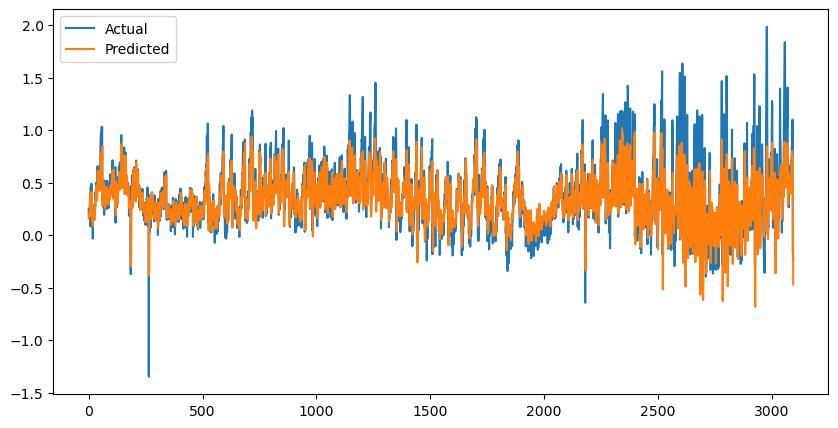

In [14]:
# 모델 예측 및 평가
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Flatten the lists
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# 예측 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()